# Joint lightcurve - radial velocity model with multivariate prior

In [1]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pickle as pk
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter
import wquantiles

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

def docs_setup():
    """Set some environment variables and ignore some warnings for the docs"""
    import logging
    import warnings


    # Remove when Theano is updated
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Remove when arviz is updated
    warnings.filterwarnings("ignore", category=UserWarning)

    logger = logging.getLogger("theano.gof.compilelock")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("exoplanet")
    logger.setLevel(logging.DEBUG)

docs_setup()

4.3.1


# LOAD IN ALLVISIT FILE (an absolute unit: ~ 2.75GB)

In [2]:
allvis17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allVisit-dr17-synspec.fits",hdu=1, format='fits')
allstar17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allStar-dr17-synspec-gaiaedr3-xm.fits")
allstar17 = allstar17[(allstar17['bp_rp'] < 10) & (allstar17['phot_g_mean_mag'] < 25)]
calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-min3-calibverr.fits', format='fits', hdu=1)


print(len(allvis17['APOGEE_ID']))
print(allvis17.columns)
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits', format='fits')
print(len(hq_jk_allstar_tess_edr3))

2659178
<TableColumns names=('APOGEE_ID','TARGET_ID','VISIT_ID','FILE','FIBERID','CARTID','PLATE','MJD','TELESCOPE','SURVEY','FIELD','PROGRAMNAME','ALT_ID','LOCATION_ID','RA','DEC','GLON','GLAT','RELFLUX','MTPFLUX','J','J_ERR','H','H_ERR','K','K_ERR','SRC_H','WASH_M','WASH_M_ERR','WASH_T2','WASH_T2_ERR','DDO51','DDO51_ERR','IRAC_3_6','IRAC_3_6_ERR','IRAC_4_5','IRAC_4_5_ERR','IRAC_5_8','IRAC_5_8_ERR','IRAC_8_0','IRAC_8_0_ERR','WISE_4_5','WISE_4_5_ERR','TARG_4_5','TARG_4_5_ERR','WASH_DDO51_GIANT_FLAG','WASH_DDO51_STAR_FLAG','PMRA','PMDEC','PM_SRC','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE_TARGET4','TARGFLAGS','SNR','STARFLAG','STARFLAGS','DATEOBS','JD','VLSR','VGSR','CHISQ','SYNTHFILE','MIN_H','MAX_H','MIN_JK','MAX_JK','VREL','VRELERR','VHELIO','BC','RV_TEFF','RV_LOGG','RV_FEH','RV_CARB','RV_ALPHA','XCORR_VREL','XCORR_VRELERR','XCORR_VHELIO','CCFWHM','AUTOFWHM','RV_CHI2','N_COMPONENTS','RV_COMPONENTS','RV_FLAG')>
1741


In [3]:
def get_multiple_ranges(lk_coll):
    from itertools import groupby
    from operator import itemgetter

    ranges =[]
    inds = []
    data = [ii.sector for ii in lk_coll]
    for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        inds.append([ii in group for ii in data])
        ranges.append((group[0],group[-1]))
        
    return data,ranges, inds



In [4]:
def get_texp_from_lightcurve(res):
    with fits.open(res['all_lks'].filename) as hdu:
        hdr = hdu[1].header

    texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
    texp /= 60.0 * 60.0 * 24.0
    print(texp, texp*60*60*24)

    return texp


Holoviews not imported. Some visualizations will not be available.


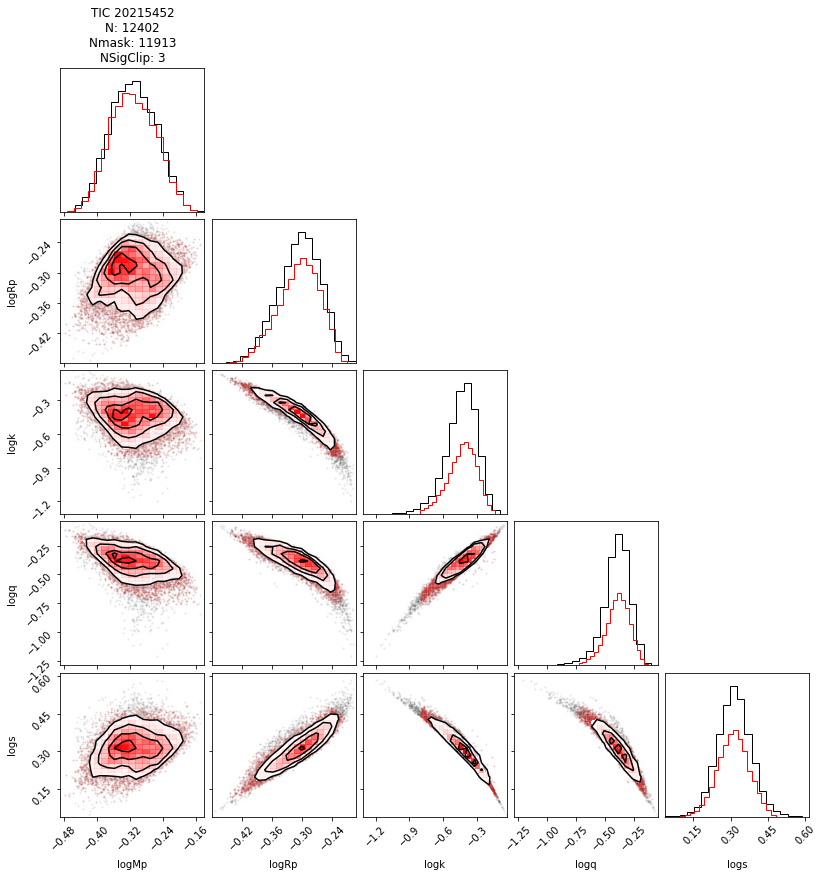

In [5]:
def get_system_data_for_pymc3_model(TICID):
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_highres_bls_params.pickle",'rb')
    blsres = pk.load(file)
    file.close()

    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_lightcurve_data.pickle","rb")
    res = pk.load(file)
    file.close()
    
        #     print(calibverr.info)
    # Grab cross-match IDs
    sysapodat = allvis17[allvis17['APOGEE_ID'] == res['joker_param']['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))
    
    return (res, blsres, sysapodat)


def highres_secondary_transit_bls(res, blsres):
    
    jk_row = res['joker_param']

    
    dur_grid = np.exp(np.linspace(np.log(0.001),np.log(0.1),1000))
    
#     npts = 5000
#     pmin = period_grid.min()
#     pmax = period_grid.max()
#     mindur = dur_grid.min()

    all_lk = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
    
    transit_mask = all_lk.create_transit_mask(
        period=blsres['period_at_max_power'].value,
        duration=5*blsres['duration_at_max_power'].value,
        transit_time=blsres['t0_at_max_power'].value
    )

    no_transit_lks = all_lk[~transit_mask]
        
#     print(f"Running BLS.")

#     maxtime = all_lk.time.max().value
#     mintime = all_lk.time.min().value

#     freq_f = int( ((pmin**-1 - pmax**-1) * (maxtime - mintime)**2) / (npts * mindur) ) 

    x = no_transit_lks.time
    y = no_transit_lks.flux
    yerr = no_transit_lks.flux_err

    cusBLS = astropy.timeseries.BoxLeastSquares(x, y, yerr)

    max_period = 100. * blsres['period_at_max_power'].value
    min_period = .011      #0.5 * jk_row['MAP_P']
    nf =   5 * 10**5    #5 * 10**5
    baseline = max(all_lk.time.value) - min(all_lk.time.value)
    
    min_f = 1. / max_period
    max_f = 1. / min_period
    
    freq_f = ( (max_f - min_f) * baseline**2. ) / ( (nf - 1) * min(dur_grid) )
    
    period_grid = np.array([blsres['period_at_max_power'].value])
                            #cusBLS.autoperiod(dur_grid, 
#                                     maximum_period = max_period,
#                                     minimum_period = min_period,
#                                     frequency_factor=freq_f)
    
#     print(nf, len(period_grid))
#     assert nf==len(period_grid)
    res = cusBLS.power(period_grid, dur_grid)

    maxpow = np.argmax(res['power'])
    cusBLSperiod = res['period'][maxpow]
    cusBLSt0 = res['transit_time'][maxpow]
    cusBLSdur = res['duration'][maxpow]
    cusBLSdepth = res['depth'][maxpow]

    res['period_at_max_power'] = cusBLSperiod
    res['t0_at_max_power'] = cusBLSt0
    res['depth_at_max_power'] = cusBLSdepth
    res['duration_at_max_power'] = cusBLSdur
    res['max_power'] = maxpow
    
    res['no_transit_lk'] = no_transit_lks
        
#     print("Finished.")

    

    
    return res


def estimate_ecosw(bls2res, blsres):
    
    bls1_t0 = blsres['t0_at_max_power']
    bls2_t0 = bls2res['t0_at_max_power']
    
    delT = (bls2_t0.value - bls1_t0.value) % blsres['period_at_max_power'].value
    
    ecosw_testval = ( (np.pi/4.) * ( (2.*delT / blsres['period_at_max_power'].value) - 1) )
    
    return ecosw_testval

# ecosw_tv = estimate_ecosw(bls2res, blsres)
# print(ecosw_tv)

def get_M1_R1_from_binary_model(TIC_TARGET, nsig=3):
    """
    FOR LATER CONSIDERATION:
    IMPLEMENT A RECURSIVE MAD-SIGMA CLIPPING THAT CONTINUES CLIPPING AT 3-MAD-SIGMA UNTIL THERE ARE 
    NO MORE CLIPPED DATA POINTS. THIS IS TO ALLOW THE ISOCHRONES POSTERIORS TO HAVE MULTIMODAL DISTRIBUTIONS
    THAT WONT AFFECT THE CONSTRUCTION OF THE MULTIVARIATE PRIOR.
    """
    from isochrones import BinaryStarModel

    ID = TIC_TARGET.split(' ')[1]
    mod = BinaryStarModel.load_hdf(f"/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_{ID}_binary_model_obj.hdf")
#     fig = corner(az.from_dict(mod.derived_samples[['mass_0','mass_1','radius_0','radius_1','Mbol_0','Mbol_1']].to_dict('list')))
    m0,m1,r0,r1,mbol0,mbol1 = mod.derived_samples[['mass_0','mass_1','radius_0', 'radius_1','Mbol_0','Mbol_1']].values.T
    
    num, denom = np.argmin([np.median(m0), np.median(m1)]), np.argmax([np.median(m0), np.median(m1)])
#     mbol_0, mbol_1 = mod.derived_samples.Mbol_0.values,mod.derived_samples.Mbol_1.values
#     num, denom = np.argmin([np.median(m0), np.median(m1)]), np.argmax([np.median(m0), np.median(m1)])
    ms, mp = [m0,m1][num], [m0,m1][denom]

#     num, denom = np.argmin([np.median(r0), np.median(r1)]), np.argmax([np.median(r0), np.median(r1)])
    rs, rp = [r0,r1][num], [r0,r1][denom]
    
#     num, denom = np.argmin([np.median(mbol0), np.median(mbol1)]), np.argmax([np.median(mbol0), np.median(mbol1)])
    mbols,mbolp = [mbol0,mbol1][num], [mbol0,mbol1][denom]
    
    mp_madSD = np.median(abs(mp - np.median(mp))) * 1.4826
    rp_madSD = np.median(abs(rp - np.median(rp))) * 1.4826
    mbp_madSD = np.median(abs(mbolp - np.median(mbolp))) * 1.4826
    
    ms_madSD = np.median(abs(ms - np.median(ms))) * 1.4826
    rs_madSD = np.median(abs(rs - np.median(rs))) * 1.4826
    mbs_madSD = np.median(abs(mbols - np.median(mbols))) * 1.4826
    
    nsig = nsig
    mp_keep = abs(mp - np.median(mp)) < nsig * mp_madSD
    rp_keep = abs(rp - np.median(rp)) < nsig * rp_madSD
    mbp_keep = abs(mbolp - np.median(mbolp)) < nsig * mbp_madSD
    
    ms_keep = abs(ms - np.median(ms)) < nsig * ms_madSD
    rs_keep = abs(rs - np.median(rs)) < nsig * rs_madSD
    mbs_keep = abs(mbols - np.median(mbols)) < nsig * mbs_madSD
    
    
    cmplt_mask = (mp_keep) & (rp_keep) & (mbp_keep) & (ms_keep) & (rs_keep) & (mbs_keep)

    
    mod.derived_samples['logMp'] = np.log(mp)
    mod.derived_samples['logRp'] = np.log(rp)
    mod.derived_samples['logk'] = np.log(rs / rp)
    mod.derived_samples['logq'] = np.log(ms / mp)
    mod.derived_samples['logs'] = np.log(mbols / mbolp)
    
    fig = corner(az.from_dict(mod.derived_samples[['logMp','logRp','logk','logq','logs']].to_dict('list')))
    fig.axes[0].set_title(TIC_TARGET + f"\nN: {cmplt_mask.shape[0]}" +f"\nNmask: {cmplt_mask.sum()}" + f"\nNSigClip: {int(nsig)}" )


    corner(az.from_dict(mod.derived_samples[['logMp','logRp','logk','logq','logs']][cmplt_mask].to_dict('list')), 
           plot_contours=False, color='red', fig=fig, zorder=10)
    
    plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET}_isochrones_BinFitCorner_w_sigmaclip.png",dpi=150, bbox_inches='tight')
    
    
    m1 = mp[cmplt_mask]
    r1 = rp[cmplt_mask]
    log_k = np.log(rs / rp)[cmplt_mask]
    log_q = np.log(ms / mp)[cmplt_mask]
    log_s = np.log(mbols / mbolp)[cmplt_mask]

    
    M1R1_mvPrior = np.array([
                            np.log(m1),
                            np.log(r1),
                             log_q
                          ]
                           )
    
    M1R1_mu = np.mean(M1R1_mvPrior, axis=-1)
    M1R1_cov = np.cov(M1R1_mvPrior)
    
    
    return (M1R1_mu, M1R1_cov, np.mean(log_k), np.std(log_k), np.mean(np.log(r1)), np.std(np.log(r1)), np.mean(log_s), np.std(log_s))
            
M1R1_mu, M1R1_cov, logk_mu, logk_sig, logr1_mu, logr1_sig, logs_mu, logs_sig = get_M1_R1_from_binary_model("TIC 20215452")
# print(isoM1,isoR1,iso_q,iso_k, iso_s)
# print(x_rv)
def fold(x, period, t0):
    hp = 0.5 * period
    return (x - t0 + hp) % period - hp

0.001388888888888889 120.00000000000003
2.2049999999999272
lightcurve N datapoints:  7309 7309 7309 transit_epoch:  2.2049999999999272
2.7437453
277.0


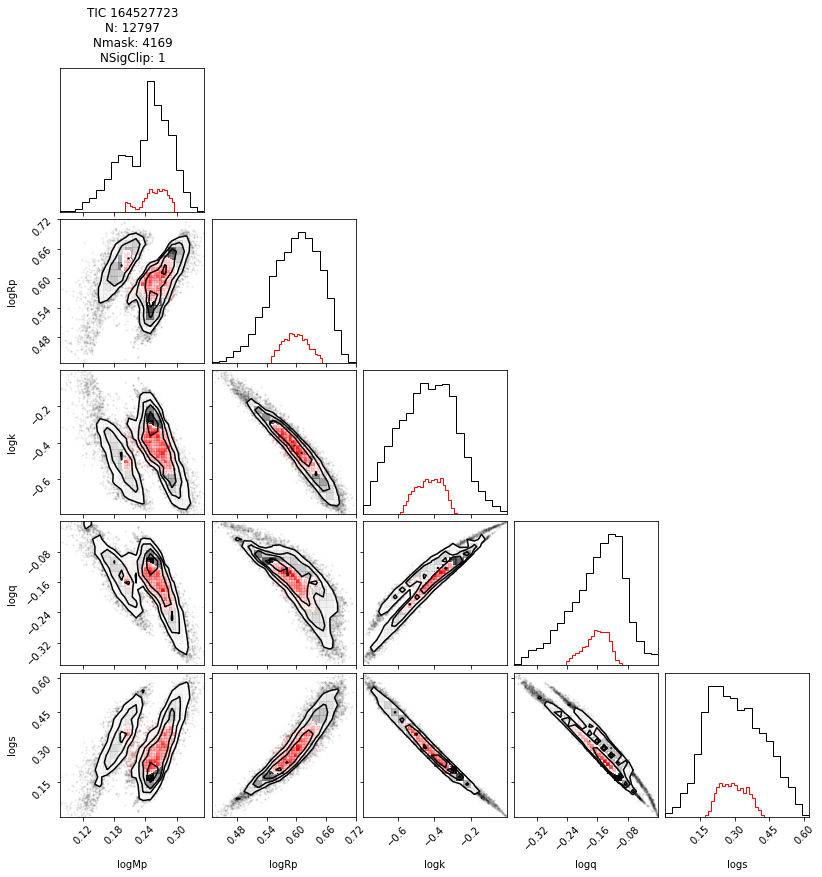

In [6]:

def load_all_data_for_pymc3_model(TIC_TARGET, sparse_factor=1, nsig=3):
    # TIC_TARGET = 'TIC 20215452'

    res, blsres, sysapodat = get_system_data_for_pymc3_model(TIC_TARGET)

    M1R1_mu, M1R1_cov, logk_mu, logk_sig, logr1_mu, logr1_sig, logs_mu, logs_sig = get_M1_R1_from_binary_model(TIC_TARGET, nsig=nsig)
    
    rv_time = astropy.time.Time(sysapodat['JD'], format='jd', scale='tcb')
    # print(sysapodat['MJD'])
    texp = get_texp_from_lightcurve(res)

    x_rv = rv_time.btjd
    y_rv = sysapodat['VHELIO'] - res['joker_param']['MAP_v0']
    yerr_rv = sysapodat['CALIB_VERR']


    model_lk_data = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize())
    x =    model_lk_data.remove_nans().time.btjd
    y =    model_lk_data.remove_nans().flux.value
    yerr = model_lk_data.remove_nans().flux_err.value

    x_lk_ref = min(x)

    x_rv = x_rv - x_lk_ref

    x = x - x_lk_ref 

    yerr = 1e3*(yerr / np.median(y))
    y = (y / np.median(y) - 1)

    y *= 1e3


    def run_with_sparse_data(x,y,yerr, use_sparse_data=False, sparse_factor=5):
        if use_sparse_data:
            np.random.seed(68594)
            m = np.random.rand(len(x)) < 1.0 / sparse_factor
            x = x[m]
            y = y[m]
            yerr = yerr[m]
        return x,y,yerr

    x,y,yerr = run_with_sparse_data(x,y,yerr,True, sparse_factor=sparse_factor)


    x = np.ascontiguousarray(x, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    yerr = np.ascontiguousarray(yerr, dtype=np.float64)


    x_rv = np.ascontiguousarray(x_rv, dtype=np.float64)
    y_rv = np.ascontiguousarray(y_rv, dtype=np.float64)
    yerr_rv = np.ascontiguousarray(yerr_rv, dtype=np.float64)

    bls_period = blsres['period_at_max_power'].value
    print(blsres['t0_at_max_power'].btjd-x_lk_ref)
    bls_t0 = blsres['t0_at_max_power'].btjd - x_lk_ref
    print('lightcurve N datapoints: ',len(x),len(y),len(yerr), 'transit_epoch: ',bls_t0)


#     apo_period = jk_row['MAP_P'].value
#     apo_t0 = map_t0 = astropy.time.Time(res['joker_param']['MAP_t0_bmjd'], format='mjd', scale='tcb').btjd

    lit_period = bls_period  #bls_period      ### THESE ARE THE TWO VARIABLES USED
    lit_t0 = bls_t0   #bls_t0             ### IN THE PYMC3 MODEL BELOW


    transit_mask = model_lk_data.create_transit_mask(
        period=blsres['period_at_max_power'].value,
        duration=5*blsres['duration_at_max_power'].value,
        transit_time=blsres['t0_at_max_power']
    )

    no_transit_lks = model_lk_data[~transit_mask]
    y_masked = 1000 * (no_transit_lks.flux.value / np.median(no_transit_lks.flux.value) - 1)
    lk_sigma = np.std(y_masked)
    print(lk_sigma)

    Ntrans = np.floor((x.max() - lit_t0) / lit_period)
    print(Ntrans)
    lit_tn = lit_t0  + Ntrans * lit_period

    bls2res = highres_secondary_transit_bls(res,blsres)
    ecosw_tv = estimate_ecosw(bls2res, blsres)

    return {
        'texp' : texp,
        'x' : x,
        'y' : y,
        'yerr' : yerr,
        'x_rv' : x_rv,
        'y_rv' : y_rv,
        'lk_sigma' : lk_sigma,
        'yerr_rv' : yerr_rv,
        'lit_period' : lit_period,
        'lit_t0' : lit_t0,
        'Ntrans' : Ntrans,
        'lit_tn' : lit_tn,
        'ecosw_tv' : ecosw_tv,
        'isores' : {
            'logM1Q' : (M1R1_mu, M1R1_cov),
            'logR1' : (logr1_mu, logr1_sig),
            'logk' : (logk_mu, logk_sig),
            'logs' : (logs_mu, logs_sig),
        }
    }


    
# bls_period, lit_period = popt[1], popt[1]
# bls_t0, lit_t0 = popt[-1]-x_lk_ref,popt[-1]-x_lk_ref
TIC_TARGET = "TIC 20215452"
pymc3_model_dict = load_all_data_for_pymc3_model("TIC 164527723", sparse_factor=10, nsig=1)


# bls_period, lit_period = popt[1], popt[1]
# bls_t0, lit_t0 = popt[-1]-x_lk_ref,popt[-1]-x_lk_ref

# fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
# # print(axes)
# axes[0][0].plot(
#     fold(x, lit_period, lit_t0), y, ".k"
# )

# axes[0][0].plot(
#     fold(no_transit_lks.time.value-x_lk_ref, lit_period, lit_t0),
#     y_masked, ",r"
# )

# axes[1][0].plot(
#     fold(x_rv, bls_period, bls_t0), y_rv, ".k",
#     label='folded with BLS'
# )
# axes[1][0].plot(
#     fold(x_rv, apo_period, apo_t0), y_rv, "+r",
#     label='folded with MAP'
# )

# axes[1][0].legend()
# axes[0][1].plot(x, y, ".k")
# axes[0][1].axvline(lit_t0, c='cyan')
# axes[0][1].axvline(lit_tn,c='cyan')
# axes[1][1].plot(x_rv-min(x_rv), y_rv, "+r")

# # x_rv = x_rv - lit_t0

# np.all(x_rv[1:] - x_rv[:-1] > 0.0)
# axes[1][0].axvline(0.0,ls='--',alpha=0.25)
# axes[1][0].axhline(0.0,ls='--',alpha=0.25)


# x1m, x1p = axes[0][0].set_xlim()
# axes[1][0].set_xlim(x1m,x1p)

In [7]:
def highres_secondary_transit_bls(res, blsres):
    
    jk_row = res['joker_param']

    
    dur_grid = np.exp(np.linspace(np.log(0.001),np.log(0.1),1000))
    
#     npts = 5000
#     pmin = period_grid.min()
#     pmax = period_grid.max()
#     mindur = dur_grid.min()

    all_lk = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
    
    transit_mask = all_lk.create_transit_mask(
        period=blsres['period_at_max_power'].value,
        duration=5*blsres['duration_at_max_power'].value,
        transit_time=blsres['t0_at_max_power'].value
    )

    no_transit_lks = all_lk[~transit_mask]
        
#     print(f"Running BLS.")

#     maxtime = all_lk.time.max().value
#     mintime = all_lk.time.min().value

#     freq_f = int( ((pmin**-1 - pmax**-1) * (maxtime - mintime)**2) / (npts * mindur) ) 

    x = no_transit_lks.time
    y = no_transit_lks.flux
    yerr = no_transit_lks.flux_err

    cusBLS = astropy.timeseries.BoxLeastSquares(x, y, yerr)

    max_period = 100. * blsres['period_at_max_power'].value
    min_period = .011      #0.5 * jk_row['MAP_P']
    nf =   5 * 10**5    #5 * 10**5
    baseline = max(all_lk.time.value) - min(all_lk.time.value)
    
    min_f = 1. / max_period
    max_f = 1. / min_period
    
    freq_f = ( (max_f - min_f) * baseline**2. ) / ( (nf - 1) * min(dur_grid) )
    
    period_grid = np.array([blsres['period_at_max_power'].value])
                            #cusBLS.autoperiod(dur_grid, 
#                                     maximum_period = max_period,
#                                     minimum_period = min_period,
#                                     frequency_factor=freq_f)
    
#     print(nf, len(period_grid))
#     assert nf==len(period_grid)
    res = cusBLS.power(period_grid, dur_grid)

    maxpow = np.argmax(res['power'])
    cusBLSperiod = res['period'][maxpow]
    cusBLSt0 = res['transit_time'][maxpow]
    cusBLSdur = res['duration'][maxpow]
    cusBLSdepth = res['depth'][maxpow]

    res['period_at_max_power'] = cusBLSperiod
    res['t0_at_max_power'] = cusBLSt0
    res['depth_at_max_power'] = cusBLSdepth
    res['duration_at_max_power'] = cusBLSdur
    res['max_power'] = maxpow
    
    res['no_transit_lk'] = no_transit_lks
        
#     print("Finished.")

    

    
    return res

In [8]:
# # bls2res = highres_secondary_transit_bls(res,blsres)

# def estimate_ecosw(bls2res, blsres):
    
#     bls1_t0 = blsres['t0_at_max_power']
#     bls2_t0 = bls2res['t0_at_max_power']
#     print(bls2_t0, bls1_t0)
#     delT = (bls2_t0.value - bls1_t0.value) % blsres['period_at_max_power'].value
    
#     ecosw_testval = ( (np.pi/4.) * ( (2.*delT / blsres['period_at_max_power'].value) - 1) )
    
#     return ecosw_testval

# ecosw_tv = estimate_ecosw(bls2res, blsres)
# print(ecosw_tv)

### ecosw =  $\frac{\pi}{4}  \frac{2delT}{P} - 1$

In [9]:
def plot_MAP_rv_curve_diagnostic_plot(model, soln, extras, mask, title,
                                        DO_NOT_PLOT=True,
                                         RETURN_FILENAME=False):
    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    
    if 'period' in soln.keys():
        period = soln['period']
    else:
        period = (lit_tn - lit_t0) / Ntrans
        
    x = extras['x']
    y = extras['y']
    t_lc_pred = np.linspace(x.min(), x.max(), 3000) 
    
    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 1000)
    
    x_rv = extras['x_rv']
    y_rv = extras['y_rv']
    
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](x), soln)
            - soln["mean_lc"]
        )

        y_rv_mod = pmx.eval_in_model(extras['model_rv'](x_phase + t0), soln) - soln['mean_rv']
    
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)

    fig, ax4 = plt.subplots(figsize=(12,18))

    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(x, y, "k.", alpha=0.2)
    ax1.plot(x, gp_pred, color="C1", lw=1)
    ax1.plot(x,lc,'C2')

    ax1.set_xlim(x.min(),x.min()+np.ceil(period))# x.max())
    plt1_ylim = ax1.set_ylim()
#     ax1.set_xlim(x.max()-10,x.max())# x.max())

#     ax2.plot(x, y - gp_pred, "k.", alpha=0.2)
#     ax2.plot(x, lc, color="C2", lw=1)
    ax2.plot(x, y-lc, color='C1', lw=2)
    
    ax2.set_ylim(plt1_ylim[0],plt1_ylim[1])
    ax2.set_xlim(x.min(),x.min()+np.ceil(period))# x.max())
#     ax2.set_xlim(x.max()-10,x.max())# x.max())
    
    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"] - t0) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[inds], extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
    ax3.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (x - t0) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = fold(x_rv, period, t0)
    ax4.plot(x_phase, y_rv_mod, "C0")
    ax4.plot(x_rv_fold, y_rv-mean, ".", label='RV obs')
    ax4.set_title(title)
    fig_filename = f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_{title.replace(' ','_')}_plot.png"
    plt.savefig(fig_filename, bbox_inches='tight', dpi=150)
    plt.close()
    
    if RETURN_FILENAME:
        return fig_filename

In [10]:
# def get_M1_R1_from_binary_model(TIC_TARGET):
#     from isochrones import BinaryStarModel

#     ID = TIC_TARGET.split(' ')[1]
#     mod = BinaryStarModel.load_hdf(f"/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_{ID}_binary_model_obj.hdf")
#     fig = corner(az.from_dict(mod.derived_samples[['mass_0','mass_1','radius_0','radius_1','Mbol_0','Mbol_1']].to_dict('list')))
#     m0,m1,r0,r1,mbol0,mbol1 = mod.derived_samples[['mass_0','mass_1','radius_0', 'radius_1','Mbol_0','Mbol_1']].values.T
    
#     num, denom = np.argmin([np.median(m0), np.median(m1)]), np.argmax([np.median(m0), np.median(m1)])
# #     mbol_0, mbol_1 = mod.derived_samples.Mbol_0.values,mod.derived_samples.Mbol_1.values
# #     num, denom = np.argmin([np.median(m0), np.median(m1)]), np.argmax([np.median(m0), np.median(m1)])
#     ms, mp = [m0,m1][num], [m0,m1][denom]

# #     num, denom = np.argmin([np.median(r0), np.median(r1)]), np.argmax([np.median(r0), np.median(r1)])
#     rs, rp = [r0,r1][num], [r0,r1][denom]
    
# #     num, denom = np.argmin([np.median(mbol0), np.median(mbol1)]), np.argmax([np.median(mbol0), np.median(mbol1)])
#     mbols,mbolp = [mbol0,mbol1][num], [mbol0,mbol1][denom]
    
#     mp_madSD = np.median(abs(mp - np.median(mp))) * 1.4826
#     rp_madSD = np.median(abs(rp - np.median(rp))) * 1.4826
#     mbp_madSD = np.median(abs(mbolp - np.median(mbolp))) * 1.4826
    
#     ms_madSD = np.median(abs(ms - np.median(ms))) * 1.4826
#     rs_madSD = np.median(abs(rs - np.median(rs))) * 1.4826
#     mbs_madSD = np.median(abs(mbols - np.median(mbols))) * 1.4826
    
#     nsig = 3.
#     mp_keep = abs(mp - np.median(mp)) < nsig * mp_madSD
#     rp_keep = abs(rp - np.median(rp)) < nsig * rp_madSD
#     mbp_keep = abs(mbolp - np.median(mbolp)) < nsig * mbp_madSD
    
#     ms_keep = abs(ms - np.median(ms)) < nsig * ms_madSD
#     rs_keep = abs(rs - np.median(rs)) < nsig * rs_madSD
#     mbs_keep = abs(mbols - np.median(mbols)) < nsig * mbs_madSD
    
    
#     cmplt_mask = (mp_keep) & (rp_keep) & (mbp_keep) & (ms_keep) & (rs_keep) & (mbs_keep)
#     fig.axes[0].set_title(TIC_TARGET + f"\nN: {cmplt_mask.shape[0]}" +f"\nNmask: {cmplt_mask.sum()}" + f"\nNSigClip: {int(nsig)}" )


#     corner(az.from_dict(mod.derived_samples[['mass_0','mass_1','radius_0','radius_1','Mbol_0','Mbol_1']][cmplt_mask].to_dict('list')), 
#            plot_contours=False, color='red', fig=fig, zorder=10)
    
#     plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET}_isochrones_BinFitCorner_w_sigmaclip.png",dpi=150, bbox_inches='tight')
    
#     m1 = mp[cmplt_mask]
#     r1 = rp[cmplt_mask]
#     log_k = np.log(rs / rp)[cmplt_mask]
#     log_q = np.log(ms / mp)[cmplt_mask]
#     log_s = np.log(mbols / mbolp)[cmplt_mask]

    
#     M1R1_mvPrior = np.array([
#                             m1,
#                              log_q
#                           ]
#                            )
    
#     M1R1_mu = np.mean(M1R1_mvPrior, axis=-1)
#     M1R1_cov = np.cov(M1R1_mvPrior)
    
    
#     return (M1R1_mu, M1R1_cov, np.mean(log_k), np.std(log_k), np.mean(np.log(r1)), np.std(np.log(r1)), np.mean(log_s), np.std(log_s))
    
# # M1R1_mu, M1R1_cov, logk_mu, logk_sig, logr1_mu, logr1_sig, logs_mu, logs_sig = get_M1_R1_from_binary_model("TIC 365204192") 
# # print(M1R1_mu)
# # print(M1R1_cov)
# # print(logk_mu, logk_sig)
# # print(lnk_sig)
# # print(lnq_sig)


In [11]:
# def get_isochrones_multivariate_dist(TIC_TARGET):
#     from isochrones import BinaryStarModel

#     ID = TIC_TARGET.split(' ')[1]
#     print(ID)
#     mod = BinaryStarModel.load_hdf(f"/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_{ID}_binary_model_obj.hdf")
#     m0,m1,r0,r1 = mod.derived_samples[['mass_0','mass_1','radius_0', 'radius_1']].values.T
    
#     mbol_0, mbol_1 = mod.derived_samples.Mbol_0.values,mod.derived_samples.Mbol_1.values

    
#     num,denom = np.argmin([m0.mean(),m1.mean()]), np.argmax([m0.mean(),m1.mean()])
# #     print(m0,m1,num,denom)
#     s =  [mbol_0,mbol_1][num] / [mbol_0,mbol_1][denom]
#     q = m0 / m1 # [m0,m1][num] / [m0,m1][denom]
#     k =r0 / r1 # [r0,r1][num] / [r0,r1][denom]
    
# #     print(m0,m1,mbol_0,mbol_1)
# #     m1, r1, q, k, s = ([m0,m1][denom],
# #                         [r0,r1][denom],
# #                         q,k,s
# #                        )
#     print(q.mean(), k.mean(), s.mean())
#     iso_multD = np.array([np.log([m0,m1][denom]), np.log([r0,r1][denom]), np.log(s)])

#     MV_mu = np.mean(iso_multD, axis=-1)
#     MV_cov = np.cov(iso_multD)
    
#     return (MV_mu, MV_cov)
# # m1, r1, q, k, s= get_isochrones_multivariate_dist("TIC 272074664")

# # MV_mu, MV_cov = get_isochrones_multivariate_dist(TIC_TARGET)
# print(MV_mu.T)
# print(np.round(MV_cov,4))
# print(np.isfinite(yerr_rv).sum(), yerr_rv.shape)
# np.log(np.median(yerr_rv))

## PYMC3 BUILD with a multivariate prior on M1, R1, Q, K, S

0.001388888888888889 120.00000000000003
1.1389999999998963
lightcurve N datapoints:  17647 17647 17647 transit_epoch:  1.1389999999998963
3.3133538
165.0
sigma_lc ~ InverseGamma sigma_gp ~ InverseGamma rho_gp ~ InverseGamma
mean_lc                         -3.22
mean_rv                         -4.14
u1_quadlimbdark__               -2.77
u2_quadlimbdark__               -2.77
BigPrior                         7.07
log_k                            0.83
log_s                            1.11
b_impact__                      -1.58
t0                              -0.92
tn                              -0.92
ecs_unitdisk+interval__         -2.31
sigma_lc_log__                  -3.05
sigma_gp_log__                  -2.69
rho_gp_log__                    -4.11
log_sigma_rv                    -3.22
obs_lc                    -2721599.67
obs                         -65884.44
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_k]


message: Optimization terminated successfully.
logp: -2787506.8128893706 -> -131064.06044724578
optimizing logp for variables: [b, log_k]


message: Optimization terminated successfully.
logp: -131064.06044724578 -> -130318.19404532689
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -130318.19404532689 -> -100905.307114645
optimizing logp for variables: [log_s]


message: Optimization terminated successfully.
logp: -100905.307114645 -> -95270.22743227161
optimizing logp for variables: [tn, t0]


message: Optimization terminated successfully.
logp: -95270.22743227161 -> -95051.82961802607
optimizing logp for variables: [u2, u1]


message: Optimization terminated successfully.
logp: -95051.82961802607 -> -94204.50019870498
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -94204.50019870498 -> -55223.731448479724
optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc]


message: Optimization terminated successfully.
logp: -55223.731448479724 -> -44805.58099382944
optimizing logp for variables: [mean_lc, mean_rv]


message: Optimization terminated successfully.
logp: -44805.58099382944 -> -44801.22857995934
optimizing logp for variables: [BigPrior]


message: Desired error not necessarily achieved due to precision loss.
logp: -44801.22857995934 -> -44254.451389465605
optimizing logp for variables: [mean_lc, mean_rv, u1, u2, BigPrior, log_s, log_k, b, t0, tn, ecs, sigma_lc, sigma_gp, rho_gp, log_sigma_rv]


message: Desired error not necessarily achieved due to precision loss.
logp: -44254.451389465605 -> -42820.759544868684


##################################################
###################  FINISHED  ###################
##################################################


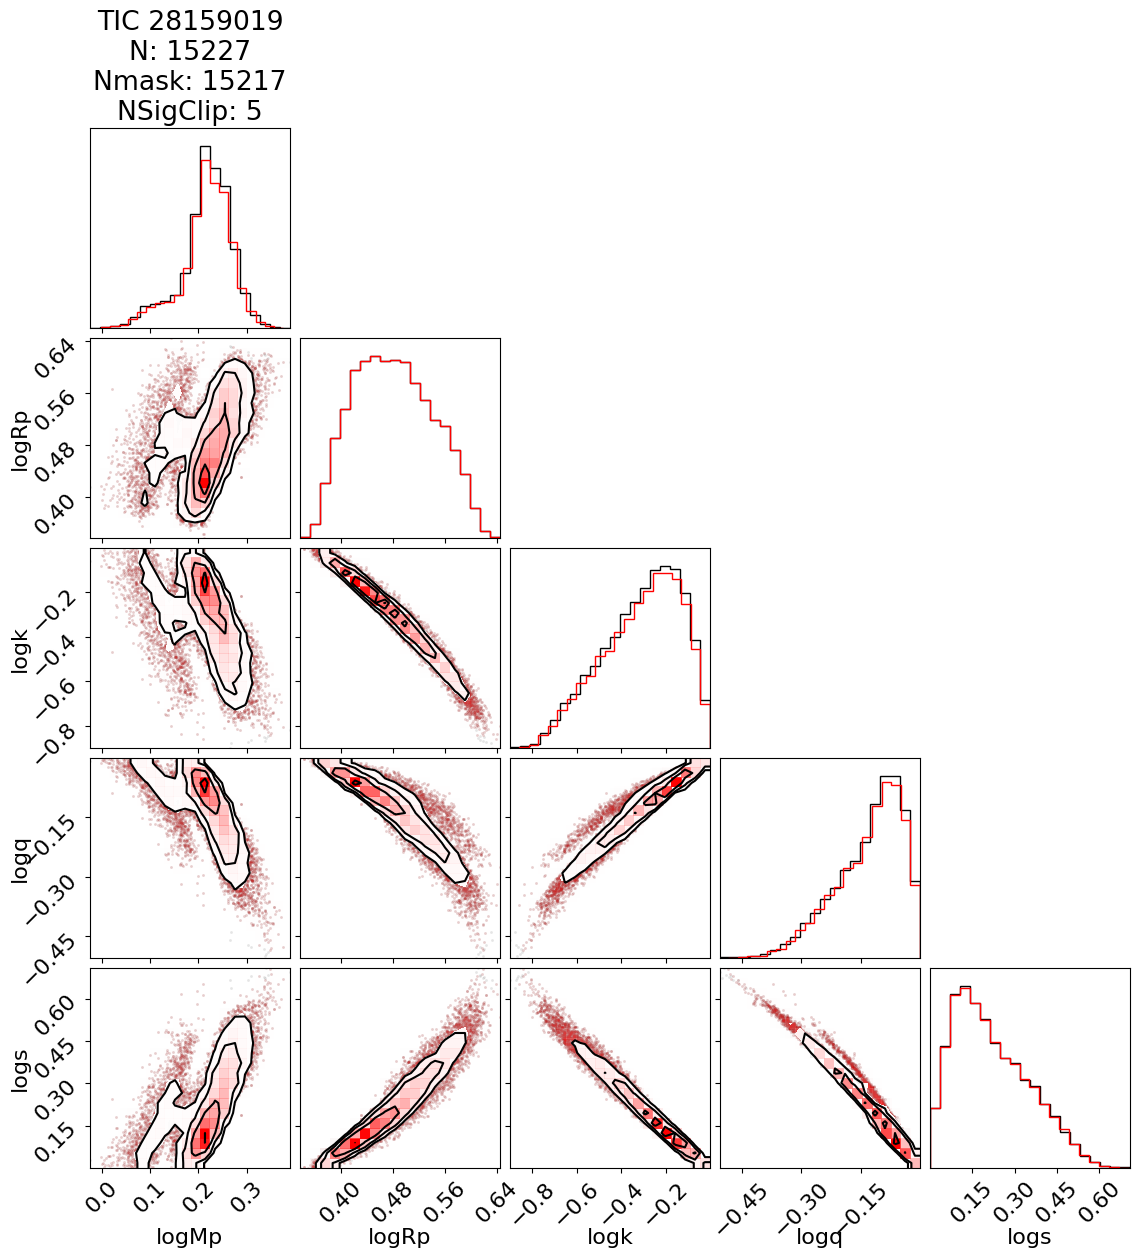

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [141]:
TIC_TARGET = "TIC 28159019"
pymc3_model_dict = load_all_data_for_pymc3_model(TIC_TARGET, sparse_factor=3, nsig=5.)

texp = pymc3_model_dict['texp']
x_rv, y_rv, yerr_rv = pymc3_model_dict['x_rv'], pymc3_model_dict['y_rv'], pymc3_model_dict['yerr_rv']
x, y, yerr = pymc3_model_dict['x'], pymc3_model_dict['y'], pymc3_model_dict['yerr']
lk_sigma = pymc3_model_dict['lk_sigma']

lit_period, lit_t0, lit_tn = pymc3_model_dict['lit_period'], pymc3_model_dict['lit_t0'], pymc3_model_dict['lit_tn']
Ntrans, ecosw_tv = pymc3_model_dict['Ntrans'], pymc3_model_dict['ecosw_tv']

M1R1_mu, M1R1_cov = pymc3_model_dict['isores']['logM1Q']
logr1_mu, logr1_sig = pymc3_model_dict['isores']['logR1']
logk_mu, logk_sig = pymc3_model_dict['isores']['logk']
logs_mu, logs_sig = pymc3_model_dict['isores']['logs']

trv = np.linspace(x_rv.min(), x_rv.max(), 5000)
tlc = np.linspace(x.min(), x.max(), 5000)

# rvK = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv*u.km/u.s, yerr_rv*u.km/u.s, t0s=bls_t0)[0]
# print(rvK)

# mask = x < 400
def build_model(mask=None, start=None, plot_MAP_diagnostic_rv_curves=False):
    if mask is None:
        mask = np.ones(len(x), dtype='bool')
    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=10.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=25.0)

        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

#         # Parameters describing the primary
#         log_M1 = pm.Normal("log_M1", 
#                            mu=np.log(isoM1), sigma=3.0, 
#                            testval=np.log(isoM1))
# #         log_R1 = pm.Uniform('log_R1', lower=np.log(1e-5), upper=np.log(1000))
#         log_R1 = pm.Normal("log_R1", 
#                            mu=np.log(isoR1), sigma=3.0, 
#                            testval=np.log(isoR1))

        BigPrior = pm.MvNormal("BigPrior",
                            mu = M1R1_mu,
                            cov = M1R1_cov,
                            shape=3,
                            testval=M1R1_mu
                           )
#         M1R1_prior = pm.MvNormal('M1R1_prior',
#                       mu = M1R1_mu,
#                       cov = M1R1_cov,
#                       shape = (2),
#                       testval = M1R1_mu
#                      )
    
    
        


        
#         Secondary ratios
        log_k = pm.Normal("log_k", mu=logk_mu, sigma=logk_sig, testval=logk_mu)  # radius ratio        
#         log_q = pm.Normal("log_q", mu=logq_mu, sigma=logq_sig, testval=logq_mu)  # mass ratio
        log_s = pm.Normal("log_s", mu=logs_mu, sigma=logs_sig, testval = logs_mu)  # surface brightness ratio
#         log_R1 = pm.Normal("log_R1", mu=logr1_mu, sigma=logr1_sig, testval = logr1_mu)
#         ratio_prior = pm.MvNormal("ratio_prior",
#                                   mu = ratio_mu,
#                                   cov = ratio_cov,
#                                   shape = (2),
#                                   testval = ratio_mu
#                                     )
        
        M1 = pm.Deterministic("M1", tt.exp(BigPrior.T[0].squeeze()))
        R1 = pm.Deterministic("R1", tt.exp(BigPrior.T[1].squeeze()))
#         k = pm.Deterministic("k", tt.exp(ratio_prior.T[0].squeeze()))
        q = pm.Deterministic("q", tt.exp(BigPrior.T[2].squeeze()))
#         s = pm.Deterministic("s", tt.exp(BigPrior.T[3].squeeze()))
#         R1 = pm.Deterministic("R1", tt.exp(log_R1))
        s = pm.Deterministic("s", tt.exp(log_s))

        # Prior on flux ratio
#         pm.Normal(
#             "flux_prior",
#             mu=0.5,
#             sigma=0.25,
#             observed=tt.exp(2 * log_k + log_s),
#         )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=tt.exp(log_k))
#         log_period = pm.Uniform(
#                 "log_period",
#                 lower=np.log(0.1),
#                 upper=np.log(3*lit_period),
#                 testval=np.log(lit_period)
#         )
            
#         log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=5.0)
#         period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)
        tn = pm.Normal("tn", mu=lit_tn, sigma=1.0)
        period = pm.Deterministic("period", (tn - t0) / Ntrans)
        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
#         ecosw_tv=0.01
        sqrt_ecosw = np.sign(ecosw_tv) * np.sqrt(abs(ecosw_tv))
        # ecs is now sqrt(ecs) even if variable name is still ecs
        ecs = pmx.UnitDisk("ecs", testval=np.array([sqrt_ecosw, 0.0]))
        # remove sqrt from ecc, rewrite as ecosW and esinW
        
        
        
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
#         R2 = pm.Deterministic("R2", tt.exp(log_k) * R1)
#         M2 = pm.Deterministic("M2", tt.exp(log_q) * M1)
        R2 = pm.Deterministic("R2", tt.exp(log_k) * R1)
        M2 = pm.Deterministic("M2", q * M1)
        
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        
        
        
        
        # Noise model for the light curve
        
        
        
        sigma_lc = pm.InverseGamma(
            "sigma_lc",
            testval= np.mean(yerr),
            **pmx.estimate_inverse_gamma_parameters(0.1,5.0)
        )
        
        
        sigma_gp = pm.InverseGamma(
            "sigma_gp",
            testval= lk_sigma,
            **pmx.estimate_inverse_gamma_parameters(0.1,10.0),
        )
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval= 2.0 * lit_period,
            **pmx.estimate_inverse_gamma_parameters(0.1,10.0)
        )
#         sigma_lc = np.mean(yerr)
#         sigma_gp = lk_sigma
#         rho_gp = 0.25*lit_period
        print(sigma_lc, sigma_gp, rho_gp)
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3.)

#         # Noise model for the radial velocities
#         sigma_rv = pm.InverseGamma(
#             "sigma_rv",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         sigma_rv_gp = pm.InverseGamma(
#             "sigma_rv_gp",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         rho_rv_gp = pm.InverseGamma(
#             "rho_rv_gp",
#             testval=2.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 25.0)
#         )
#         kernel_rv = terms.SHOTerm(sigma=sigma_rv_gp, w0=rho_rv_gp, Q=1.0 / 3.)

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)

        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:,0]
            )

#         pm.Deterministic(
#             "lc_pred",
#             model_lc(tlc)
#         )
        
        # Condition the light curve model on the data
        gp_lc = GaussianProcess(kernel_lc, t=x[mask], yerr=sigma_lc)
        gp_lc.marginal("obs_lc", observed=y[mask] - model_lc(x[mask]))

#         gp_pred = pm.Deterministic("gp_pred",gp_lc.predict(y[mask] - model_lc(x[mask])))
#         # Set up the radial velocity model


        log_sigma_rv = pm.Normal(
            "log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=10.
        )

        def model_rv(t):
            return orbit.get_radial_velocity(t, output_units=u.km/u.s) + mean_rv
            
        rv_model = model_rv(x_rv)
        
#         def model_K(t, period, t0):
#             rvs = model_rv(t)
#             modK = xo.estimate_semi_amplitude(period, t, rvs, yerr_rv, t0).to(u.km/u.s)
#             return modK
#         rv_pred = pm.Deterministic('rv_pred', model_rv(trv))
    
        err = tt.sqrt(yerr_rv**2. + tt.exp(2*log_sigma_rv))
        
        pm.Normal("obs",mu=rv_model, sd=err, observed=y_rv)

        
#         ## compute phased RV signal
#         n = 2.*np.pi * (1./period)
#         phi = (t0 * n) - omega
#         phase = np.linspace(0, 1, 500)
#         M_pred = 2 * np.pi * phase - (phi)
#         f_pred = xo.orbits.get_true_anomaly(M_pred, ecc + tt.zeros_like(M_pred))
        
# #         K = xo.estimate_semi_amplitude(period, t, rv_model, yerr_rv, t0).to(u.km/u.s)
#         K = (tt.max(rv_model) - tt.min(rv_model)) / 2.
    
#         rvphase = pm.Deterministic(
#             "rvphase", K * (tt.cos(omega) * (tt.cos(f_pred) + ecc) - tt.sin(omega) * tt.sin(f_pred))
#         )
        
        # Optimize the logp
        if start is None:
            start = model.test_point

            
        extras = dict(
            x=x[mask],
            y=y[mask],
            x_rv = x_rv,
            y_rv = y_rv,
            model_lc=model_lc,
            model_rv=model_rv,
            gp_lc_pred=gp_lc.predict(y[mask] - model_lc(x[mask])),
        )
        
        
        # First the RV parameters
        print(model.check_test_point())
        opti_logp = []
        filename_list = []
        
        plot = plot_MAP_rv_curve_diagnostic_plot(model, start, extras, mask, title=f'RVs after start point opt step',RETURN_FILENAME=True)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(start, log_k, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after log_k opt step',RETURN_FILENAME=True)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, b, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after b opt step',RETURN_FILENAME=True)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, ecs, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after [ecs] opt step', RETURN_FILENAME=True)
        filename_list.append(plot) 
        ecs_logp = -info_['fun']
        
        
        map_soln, info_ = pmx.optimize(map_soln, log_s, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after log_s opt step',RETURN_FILENAME=True)
        filename_list.append(plot) 
        
#         map_soln, info_ = pmx.optimize(map_soln, log_R1, return_info=True)
#         plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after log_R1 opt step',RETURN_FILENAME=True)
#         filename_list.append(plot)    
#         map_soln, info_ = pmx.optimize(map_soln, ratio_prior, return_info=True)
#         plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after ratio prior opt step', RETURN_FILENAME=True)
#         filename_list.append(plot)  
        

#         map_soln, info_ = pmx.optimize(map_soln, log_q, return_info=True)
#         plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after log_q opt step', RETURN_FILENAME=True)
#         filename_list.append(plot)
        

        
        map_soln, info_ = pmx.optimize(map_soln, [t0,tn], return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after [tn,t0] opt step', RETURN_FILENAME=True)
        filename_list.append(plot) 

        map_soln, info_ = pmx.optimize(map_soln, [u1,u2], return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after [u1, u2] opt step', RETURN_FILENAME=True)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, log_sigma_rv, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after [log_sigma_rv] opt step', RETURN_FILENAME=True)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, [sigma_lc, sigma_gp, rho_gp], return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after GP params opt step', RETURN_FILENAME=True)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, [mean_rv,mean_lc], return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after [mean_lc, mean_rv] opt step',RETURN_FILENAME=True)
        filename_list.append(plot)
#         map_soln, info_ = pmx.optimize(map_soln, M1R1_prior, return_info=True)
#         plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after M1R1prior opt step', RETURN_FILENAME=True)
#         filename_list.append(plot)  

        if ~np.isfinite(ecs_logp):
            map_soln, info_ = pmx.optimize(map_soln, ecs, return_info=True)
            plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after [ecs] opt step', RETURN_FILENAME=True)
            filename_list.append(plot) 
    
        map_soln, info_ = pmx.optimize(map_soln, BigPrior, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after BigPriors opt step', RETURN_FILENAME=True)
        filename_list.append(plot)         

        map_soln, info_ = pmx.optimize(map_soln, 
                                       [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_k, log_s, BigPrior, u2, u1, mean_rv, mean_lc],
                                       return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after final opt step', RETURN_FILENAME=True)
        filename_list.append(plot)


    return model, map_soln, extras, start, opti_logp, filename_list




model, map_soln, extras, start, opti_logp, filename_list = build_model(plot_MAP_diagnostic_rv_curves=True)

import imageio
images = []

filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
for filename in filename_list:
    images.append(imageio.imread(filename))
imageio.mimsave(f'/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET}_multivariate_prior_diagnostic_movie_test.gif', images, fps=0.75)

print("#" * 50)
print("#"*19 +"  FINISHED  " + "#"*19)
print("#"*50)

{'mean_lc': array(0.), 'mean_rv': array(0.), 'u1_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'u2_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'BigPrior': array([ 0.21593149,  0.4812132 , -0.12918958]), 'log_k': array(-0.30921378), 'log_s': array(0.21920562), 'b_impact__': array(-0.90342742), 't0': array(1.139), 'tn': array(763.2109654), 'ecs_unitdisk+interval__': array([-1.64969106,  0.        ]), 'sigma_lc_log__': array(1.06368425), 'sigma_gp_log__': array(1.1979609), 'rho_gp_log__': array(2.2232427), 'log_sigma_rv': array(-1.21106004)}


<Figure size 1200x800 with 0 Axes>

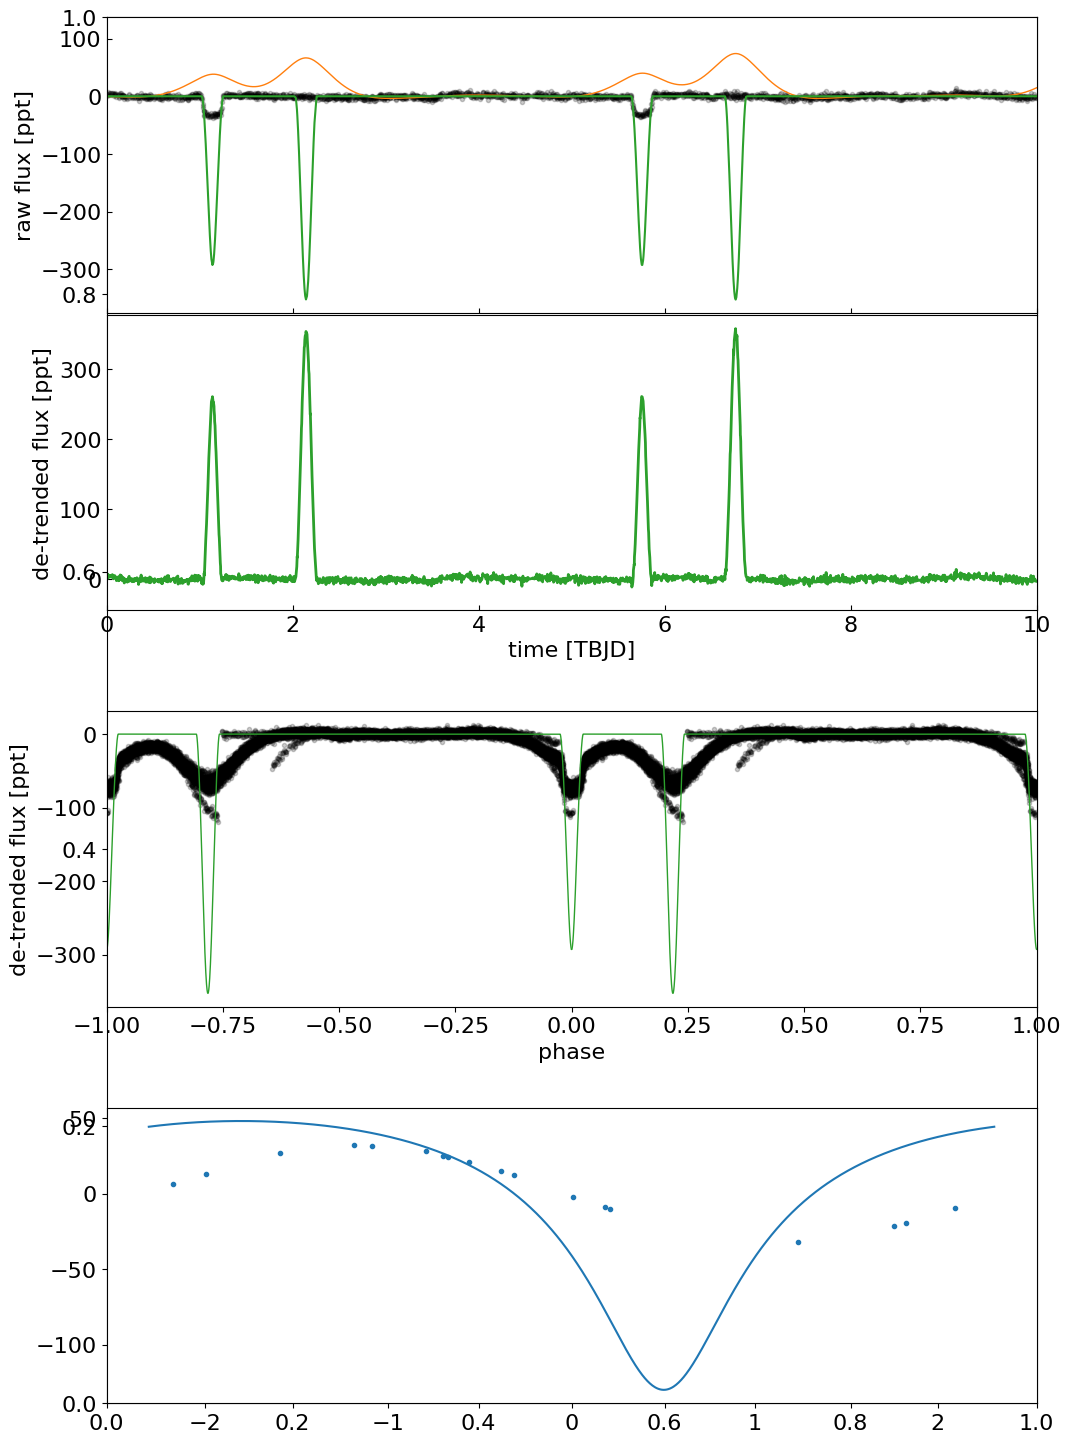

In [142]:
def plot_diagnostic_plots(soln, extras, mask, title,
                                        DO_NOT_SAVE=True):
    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    
    if 'period' in soln.keys():
        period = soln['period']
    else:
        period = (soln['tn'] - soln['t0']) / Ntrans
    x = extras['x']
    y = extras['y']
    t_lc_pred = np.linspace(x.min(), x.max(), 3000) 
    
    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 1000)
    
    x_rv = extras['x_rv']
    y_rv = extras['y_rv']
    
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](x), soln)
            - soln["mean_lc"]
        )

        y_rv_mod = pmx.eval_in_model(extras['model_rv'](x_phase + t0), soln) - soln['mean_rv']
    
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)

    fig, ax4 = plt.subplots(figsize=(12,18))

    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(x, y, "k.", alpha=0.2)
    ax1.plot(x, gp_pred, color="C1", lw=1)
    ax1.plot(x,lc,'C2')

    ax1.set_xlim(x.min(),x.min()+10.)# x.max())
#     ax1.set_xlim(x.max()-10,x.max())# x.max())

#     ax2.plot(x, y - gp_pred, "k.", alpha=0.2)
#     ax2.plot(x, lc, color="C2", lw=1)
    ax2.plot(x, y-lc, color='C2', lw=2)
    
    ax2.set_xlim(x.min(),x.min()+10)# x.max())
#     ax2.set_xlim(x.max()-10,x.max())# x.max())
    
    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"] - t0) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[inds], extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
    ax3.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (x - t0) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = (x_rv - t0 + 0.5*period) % period - 0.5*period
    ax4.plot(x_phase, y_rv_mod, "C0")
    ax4.plot(fold(x_rv,period,t0), y_rv-mean, ".", label='RV obs')
    ax4.set_title(title)
    if DO_NOT_SAVE is False:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_{title.replace(' ','_')}_plot.png",
                bbox_inches='tight', dpi=150)
        plt.close()
    
plot_diagnostic_plots(start, extras, mask=None, title='',DO_NOT_SAVE=True),
print(start)

<Figure size 1200x800 with 0 Axes>

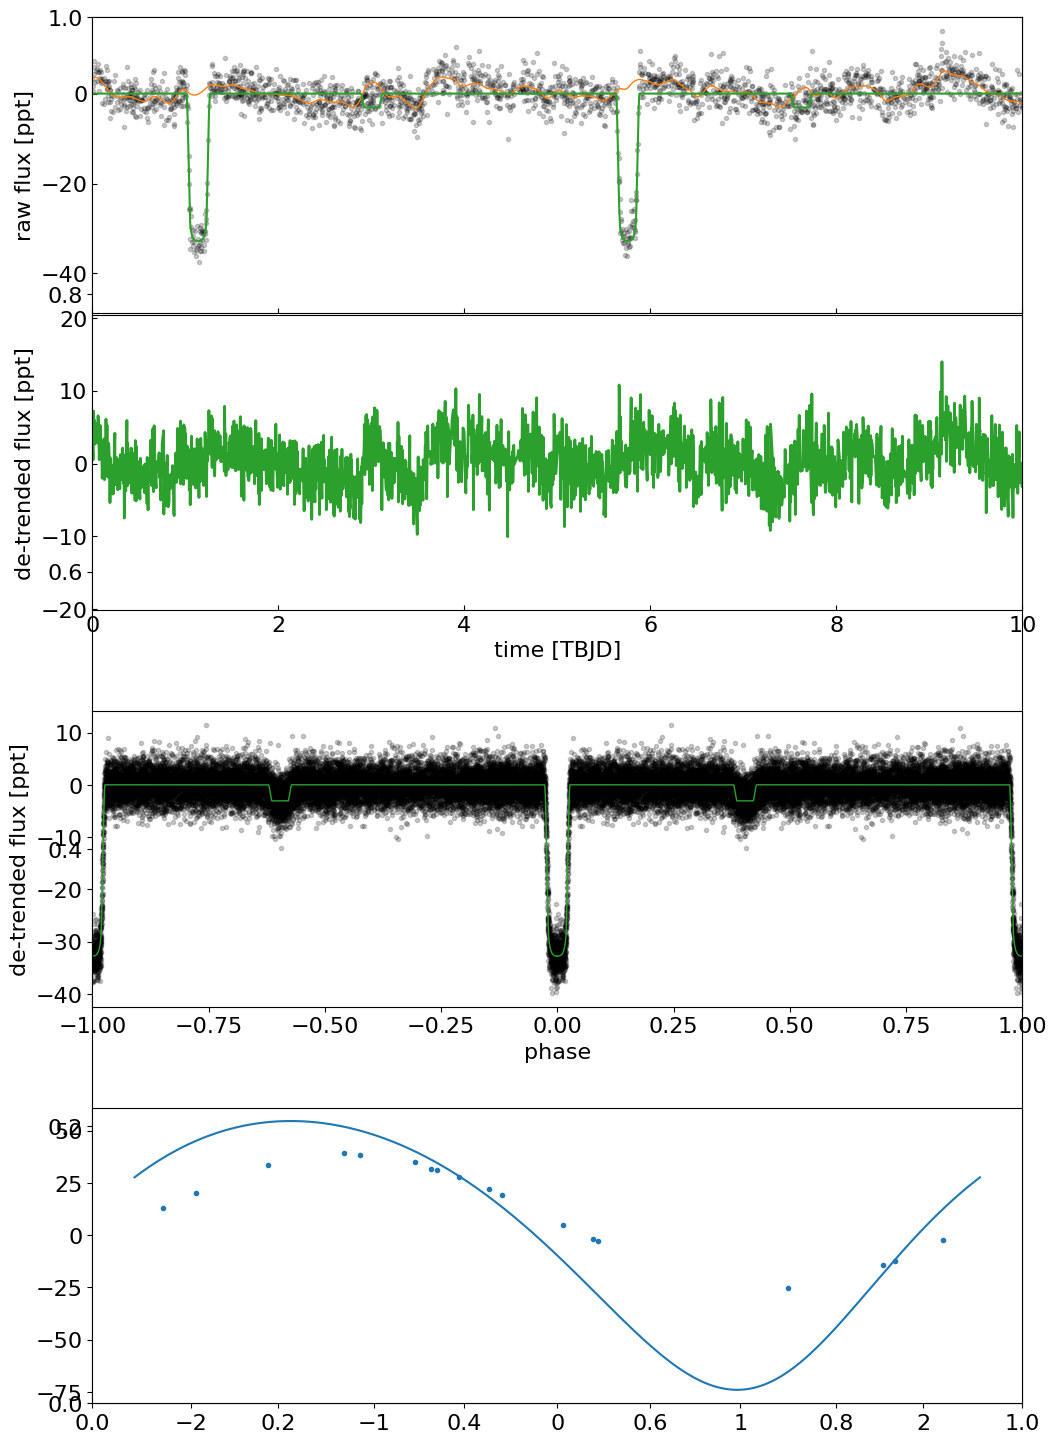

In [143]:
plot_diagnostic_plots(map_soln, extras, title='',mask=None)
plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_plot_after_brute_force_MAP.png",dpi=150, bbox_inches='tight')

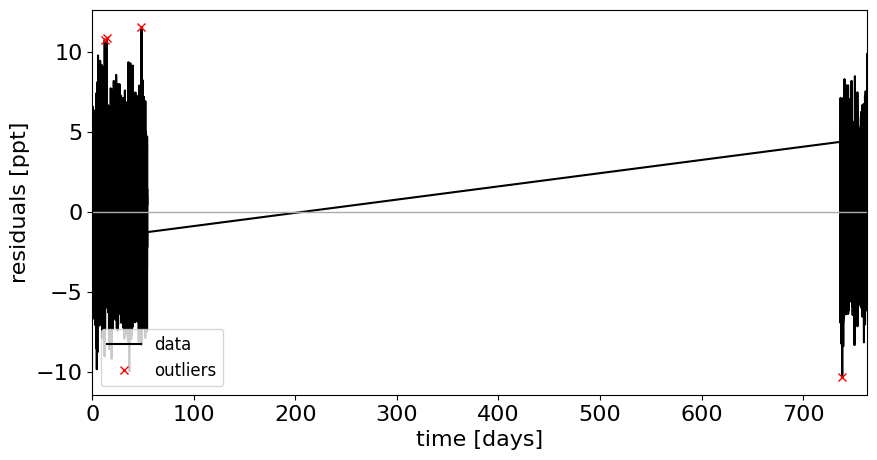

In [144]:
with model:
    mod = pmx.eval_in_model(
        extras['model_lc'](extras['x']) + extras['gp_lc_pred'],
        map_soln,
    )
    
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 6 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

sigma_lc ~ InverseGamma sigma_gp ~ InverseGamma rho_gp ~ InverseGamma
mean_lc                         -3.22
mean_rv                         -4.14
u1_quadlimbdark__               -2.77
u2_quadlimbdark__               -2.77
BigPrior                         7.07
log_k                            0.83
log_s                            1.11
b_impact__                      -1.58
t0                              -0.92
tn                              -0.92
ecs_unitdisk+interval__         -2.31
sigma_lc_log__                  -3.05
sigma_gp_log__                  -2.69
rho_gp_log__                    -4.11
log_sigma_rv                    -3.22
obs_lc                    -2721431.69
obs                         -65884.44
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_k]


message: Optimization terminated successfully.
logp: -42776.03921220998 -> -42776.039210081355
optimizing logp for variables: [b, log_k]


message: Optimization terminated successfully.
logp: -42776.039210081355 -> -42776.03920690957
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -42776.03920690957 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


optimizing logp for variables: [log_s]


message: Optimization terminated successfully.
logp: -42776.03920690957 -> -42776.039144550035


optimizing logp for variables: [tn, t0]


message: Optimization terminated successfully.
logp: -42776.039144550035 -> -42776.03914051053
optimizing logp for variables: [u2, u1]


message: Optimization terminated successfully.
logp: -42776.03914051053 -> -42776.0391349763
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -42776.0391349763 -> -42776.03913497623


optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc]


message: Optimization terminated successfully.
logp: -42776.03913497623 -> -42775.96167833741
optimizing logp for variables: [mean_lc, mean_rv]


message: Optimization terminated successfully.
logp: -42775.96167833741 -> -42775.96165591511


optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -42775.96165591511 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


optimizing logp for variables: [BigPrior]


message: Desired error not necessarily achieved due to precision loss.
logp: -42775.96165591511 -> -42775.961649619065
optimizing logp for variables: [mean_lc, mean_rv, u1, u2, BigPrior, log_s, log_k, b, t0, tn, ecs, sigma_lc, sigma_gp, rho_gp, log_sigma_rv]


message: Desired error not necessarily achieved due to precision loss.
logp: -42775.961649619065 -> -42775.960535022125


17647 17643


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

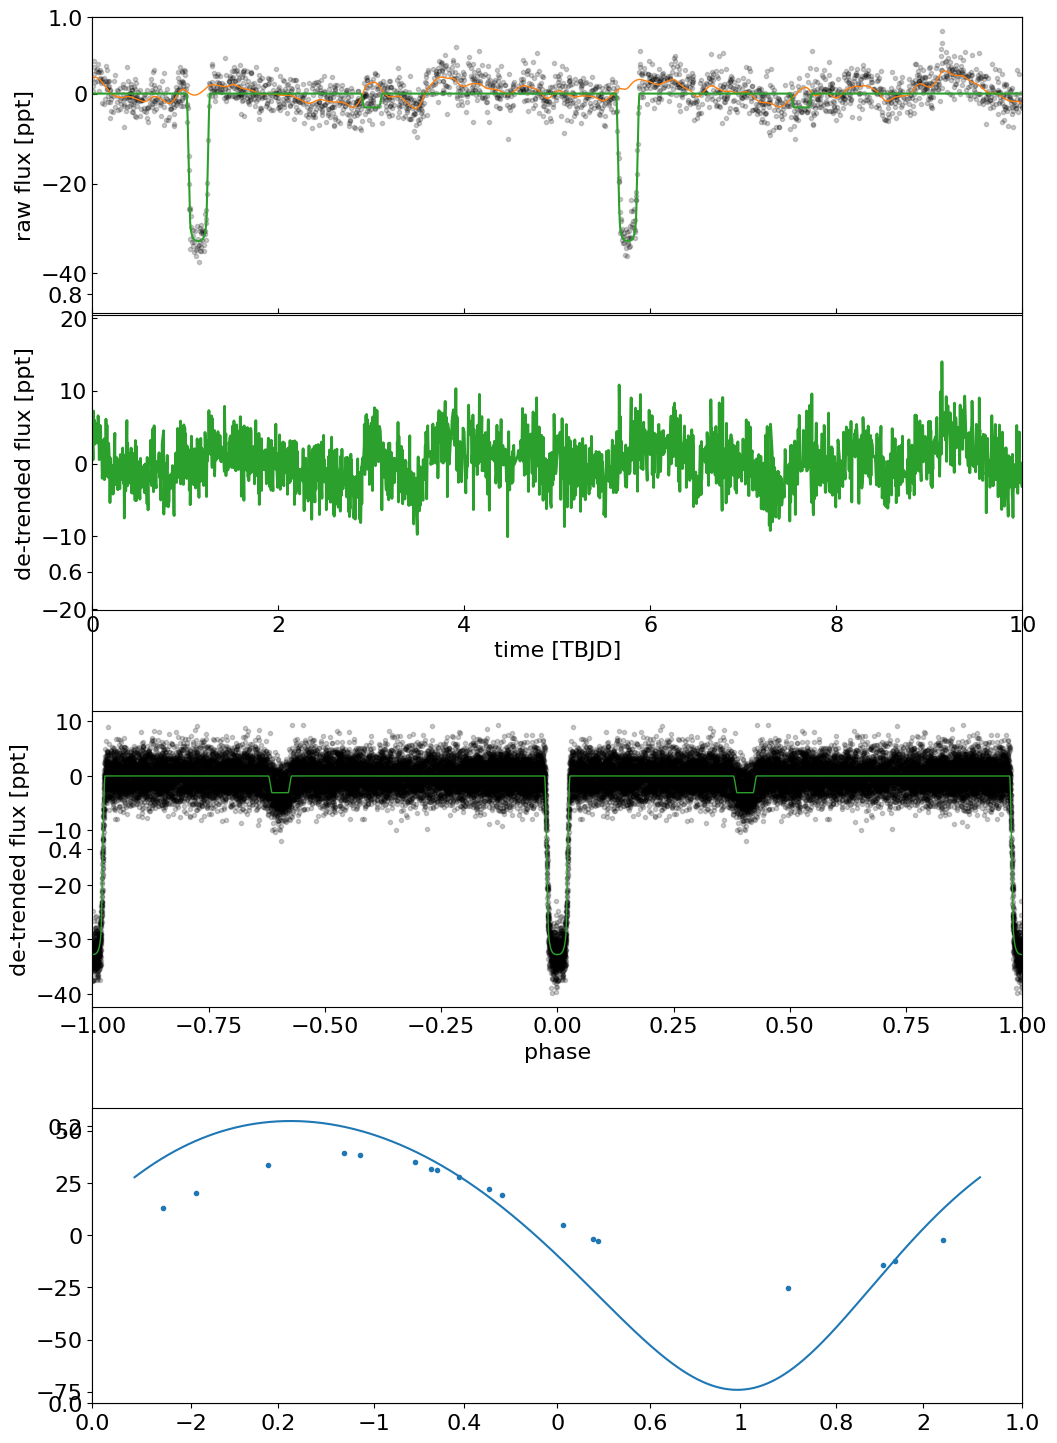

In [145]:
model, map_soln, extras, start, opti_logp,_ = build_model(mask, map_soln)
print(len(mask), len(extras['x']))
plot_diagnostic_plots(map_soln, extras, mask=None,title='')

In [146]:
Ntune = 1000
Ndraw = 500
chains = 4
with model:
    trace = pm.sample(
        tune=Ntune,
        draws=Ndraw,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=chains,
        chains=chains,
        target_accept=0.99,
        return_inferencedata=True,
        random_seed=[261136681, 261136682,261136683,261136684],#261136685, 261136686,261136687,261136688],
        init='adapt_full'
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_s, log_k, BigPrior, u2, u1, mean_rv, mean_lc]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1711 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [147]:
file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}.pickle",'wb')
pk.dump(trace,file)
file.close()

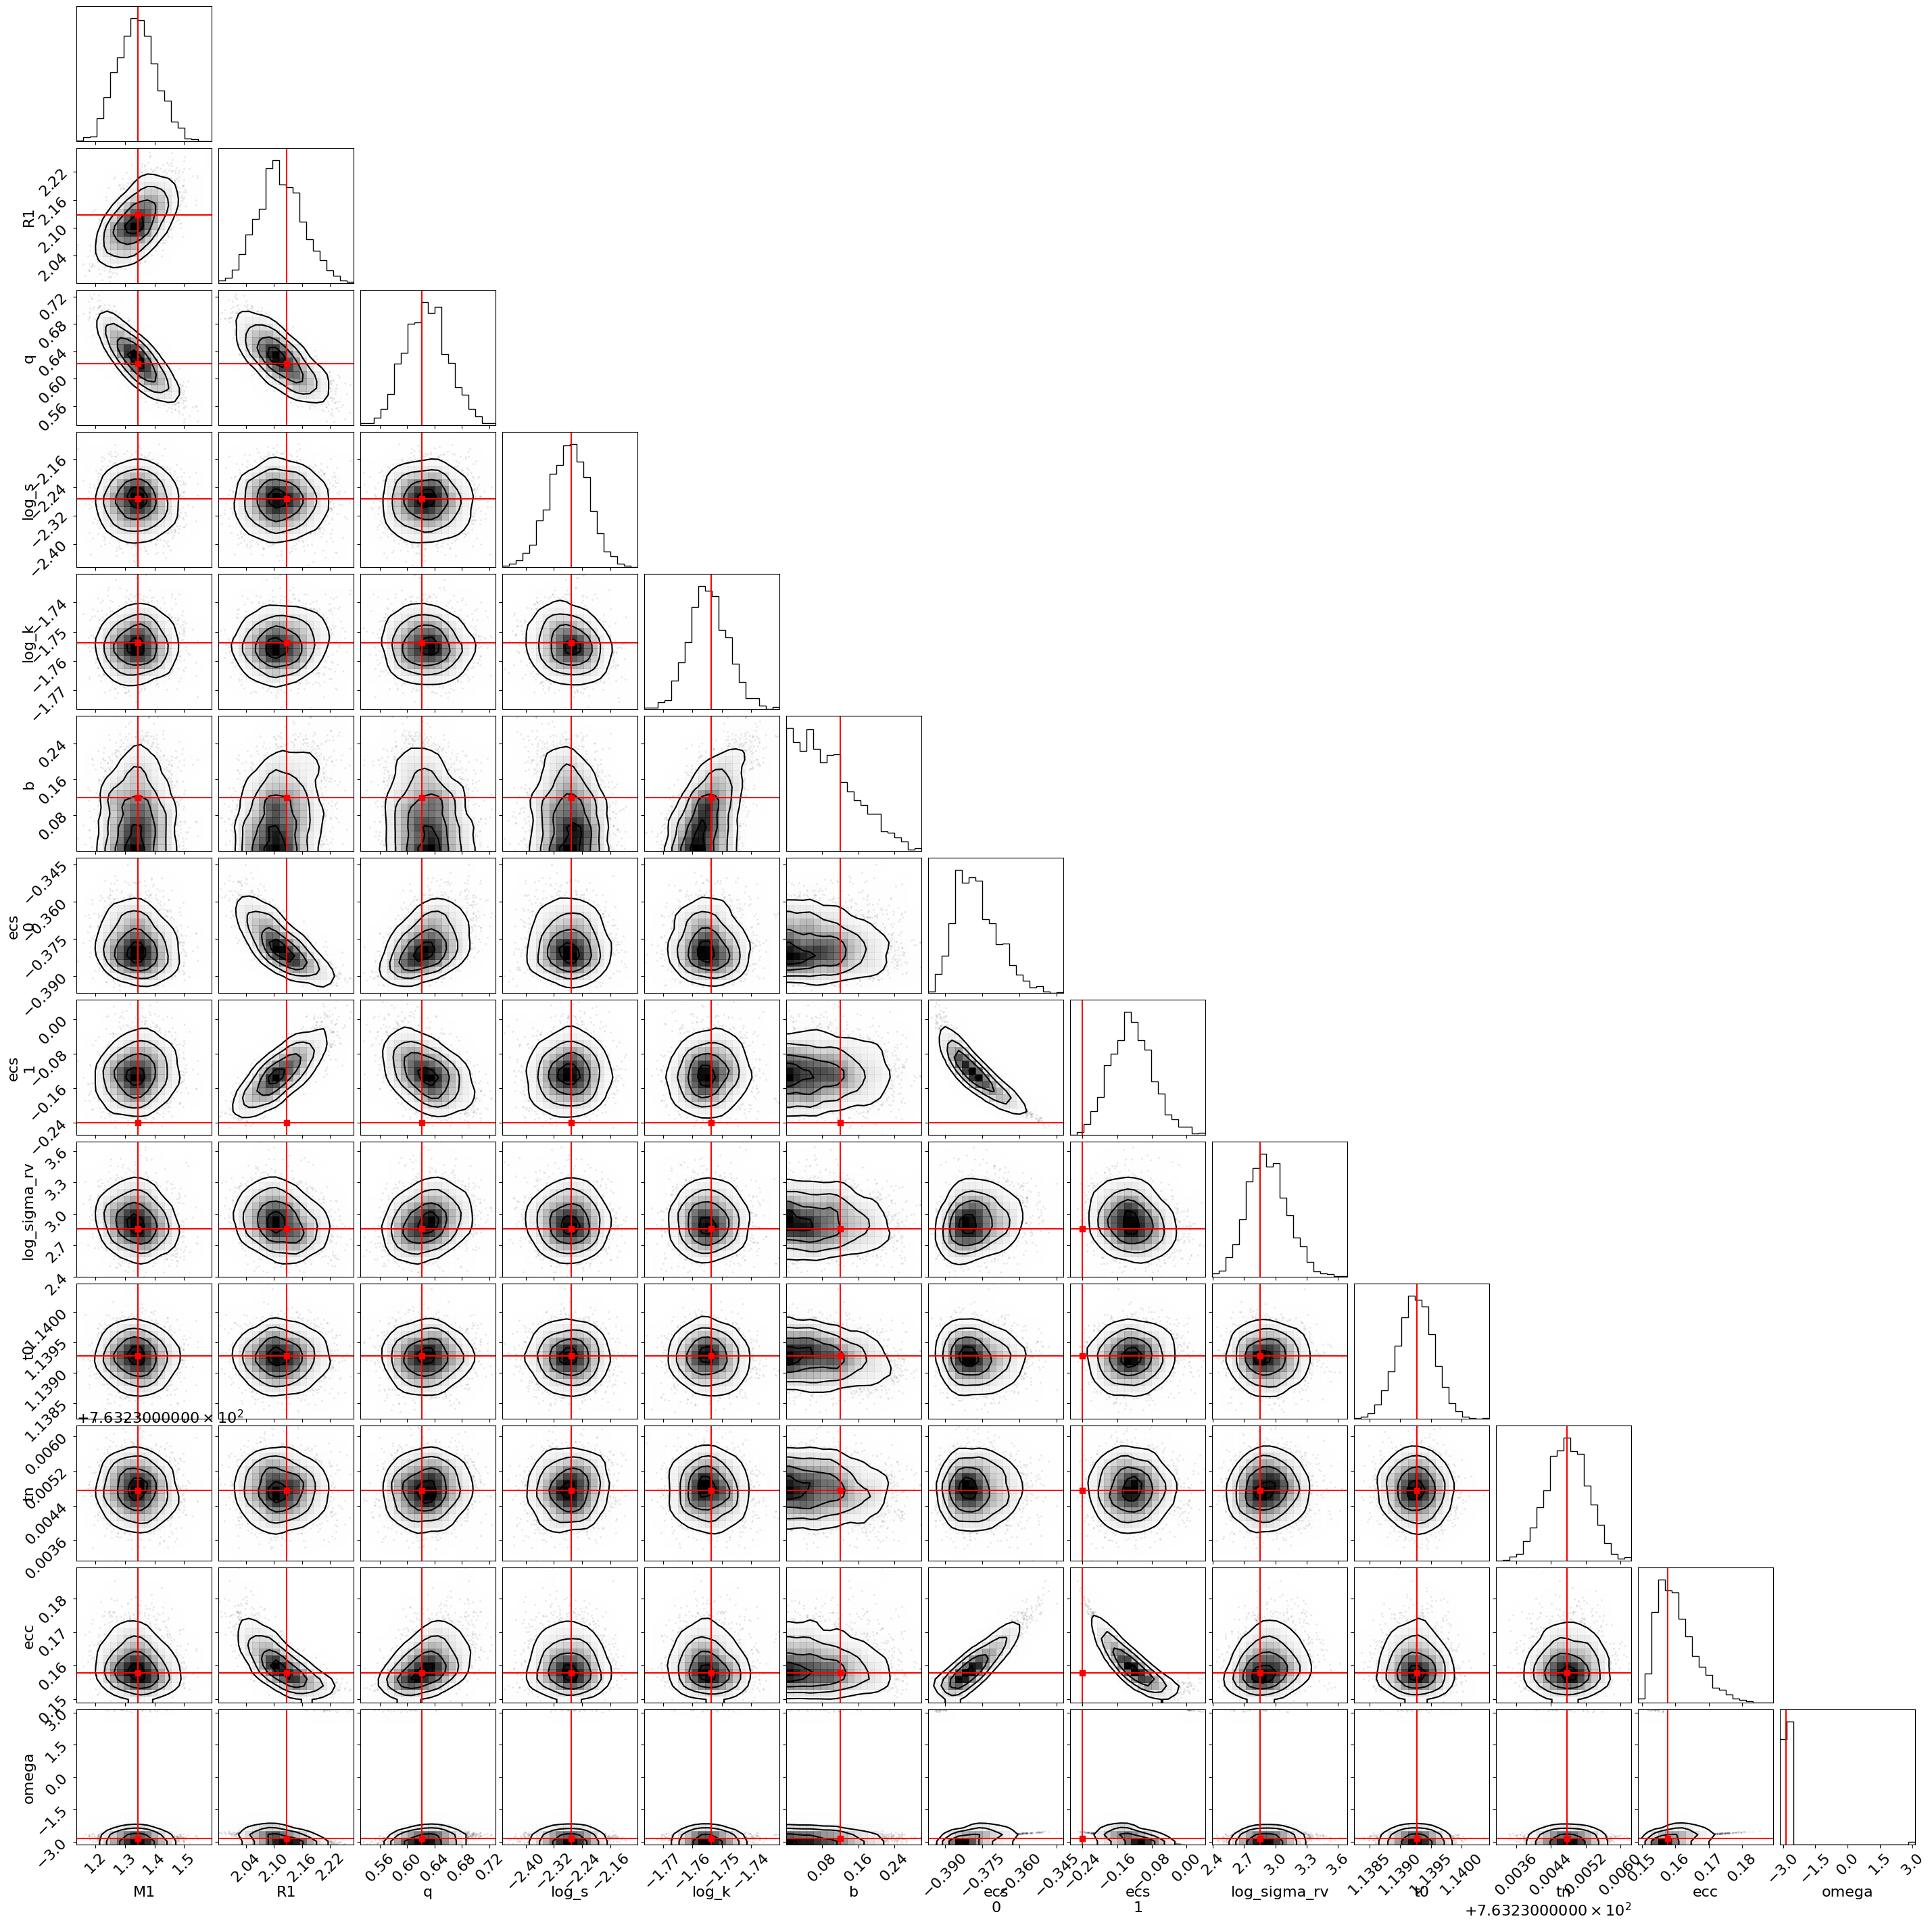

In [151]:
from corner import corner
_ = corner(trace, var_names=['M1','R1','q','log_s','log_k','b','ecs','log_sigma_rv','t0','tn','ecc', 'omega'], smooth=1, use_math_text=True,
          truths=[map_soln['M1'], map_soln['R1'], map_soln['q'], map_soln['log_s'], map_soln['log_k'], map_soln['b'], 
                  map_soln['ecs_unitdisk+interval__'][0],map_soln['ecs_unitdisk+interval__'][1], map_soln['log_sigma_rv'], 
                  map_soln['t0'], map_soln['tn'], map_soln['ecc'], map_soln['omega']],
            truth_color='red', range=[1,1,1,1,1,1,1,1,1,1,1,1,1])
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET.replace(' ','_')}_joint_rv_lightcurve_corner_w_MVnormal_prior.png",bbox_inches='tight', dpi=150)

In [169]:
file = open("tic28159019_joint_mod_individual_priors_map_soln.pickle","rb")
individual_map_soln = pk.load(file)
file.close()
map_soln['log_M1'] = map_soln['BigPrior'][0]
map_soln['log_R1'] = map_soln['BigPrior'][1]
map_soln['log_q'] = map_soln['BigPrior'][2]

prior_names = ['log_sigma_rv', 'rho_gp', 'sigma_gp', 'sigma_lc', 'ecs', 'tn', 't0', 'b', 'log_s', 'log_k', 'BigPrior', 'u2', 'u1', 'mean_rv', 'mean_lc']

for solns in prior_names:
    if solns in individual_map_soln.keys():
        print(f"del {solns}:  {map_soln[solns]-individual_map_soln[solns]}")

del log_sigma_rv:  3.802901413400342
del rho_gp:  -0.5081720461946271
del sigma_gp:  -0.030606602248183012
del sigma_lc:  0.0016540387210306484
del ecs:  [-0.40728317 -0.02192091]
del tn:  4.529414684384392e-05
del t0:  2.2757573496789973e-06
del b:  -0.1316015410278802
del log_s:  0.13795598430833111
del log_k:  -0.014088955623992261
del u2:  [-0.18112136  0.07646219]
del u1:  [-0.04084322  0.18469926]
del mean_rv:  -6.807355244137142
del mean_lc:  0.7389542909766196


In [149]:
from pymc3.util import get_default_varnames, get_untransformed_name, is_transformed_name
import theano

def compute_value_in_post(model, idata, target, size=None):
    # Get the names of the untransformed variables
    vars = get_default_varnames(model.unobserved_RVs, True)
    names = list(sorted(set([
        get_untransformed_name(v.name)
        if is_transformed_name(v.name)
        else v.name
        for v in vars
    ])))

    # Compile a function to compute the target
    func = theano.function([model[n] for n in names], target, on_unused_input="ignore")

    # Call this function for a bunch of values
    flat_samps = idata.posterior.stack(sample=("chain", "draw"))
    if size is None:
        indices = np.arange(len(flat_samps.sample))
    else:
        indices = np.random.randint(len(flat_samps.sample), size=size)

    return [func(*(flat_samps[n].values[..., i] for n in names)) for i in indices]


rvvals = compute_value_in_post(model, trace, extras['model_rv'](trv), size=1000)
lcvals = compute_value_in_post(model, trace, extras['model_lc'](tlc), size=1000)
print(np.shape(rvvals), np.shape(lcvals))
# inds = np.argsort(foldedtrv)
# for ii in range(1000):
#     axes.plot(foldedtrv,rvals[ii],'.r',alpha=0.1)
# axes.hist(rvals)
print(np.percentile(rvvals, [16,50,84],axis=0).shape)

(1000, 5000) (1000, 5000)
(3, 5000)


<xarray.DataArray 'ecc' ()>
array(0.15939765)


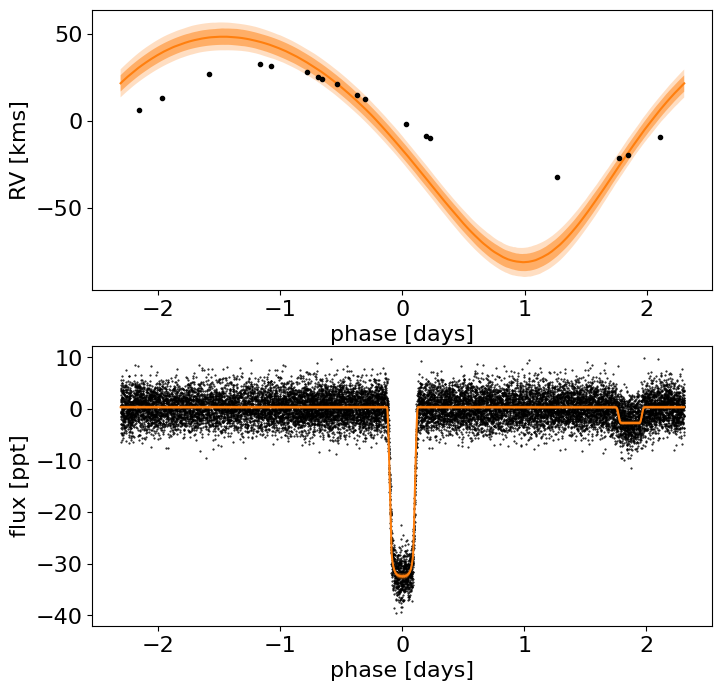

In [150]:
xo.utils.docs_setup()


# phase = np.linspace(0,1.,500)
# per = trace.posterior['period'].values
# t0 = trace.posterior['t0'].values
# x_phase = np.linspace(-0.5*np.median(per), 0.5*np.median(per), 100)

# mu_rv = trace.posterior['mean_rv'].values

flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# bkg = trace.posterior["mean_rv"].values
# rvphase = trace.posterior["rvphase"].values
# mcmc_per = trace.posterior['period'].values
p_med = flat_samps['period'].median().values
t0_med = flat_samps['t0'].median().values
mean_rv = flat_samps['mean_rv'].median().values
mean_lc = flat_samps['mean_lc'].median().values
# gp_pred = flat_samps['gp_pred'].median().values

fig, axes = plt.subplots(figsize=(8, 8), ncols=1, nrows=2)
print(flat_samps['ecc'].median())

axes[0].errorbar(fold(x_rv, p_med, t0_med),
              y_rv, yerr=yerr_rv, fmt=".k")

    
t_fold = fold(trv, p_med, t0_med)
inds = np.argsort(t_fold)
pred = np.percentile(rvvals, [16, 50, 84], axis=0)
axes[0].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

pred = np.percentile(rvvals, [16, 84], axis=0)
art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(rvvals, [5, 95], axis=0)
art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
art.set_edgecolor("none")

# pred = np.percentile(rvvals, [1, 99], axis=0)
# art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
# art.set_edgecolor("none")
# axes[0].set_ylim(-40, 40)
# axes[1].set_ylim(-40, 40)
axes[0].set_xlabel('phase [days]')
axes[0].set_ylabel("RV [kms]")

x,y = extras['x'],extras['y']
with model:
    gp_pred = (
        pmx.eval_in_model(extras["gp_lc_pred"], map_soln)
    )
axes[1].errorbar(fold(x, p_med, t0_med),
              y-gp_pred, fmt=".k", ms=1, zorder=-1)

t_fold = fold(tlc, p_med, t0_med)
inds = np.argsort(t_fold)
pred = np.percentile(lcvals, [16, 50, 84], axis=0)
axes[1].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

pred = np.percentile(lcvals, [16, 84], axis=0)
art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(lcvals, [5, 95], axis=0)
art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
art.set_edgecolor("none")

# pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
# art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
# art.set_edgecolor("none")

axes[1].set_xlabel("phase [days]")
axes[1].set_ylabel("flux [ppt]")
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET.replace(' ','_').replace('-','_')}_sampled_rvphase_plot.png",dpi=150,bbox_inches='tight')
# plt.tight_layout()

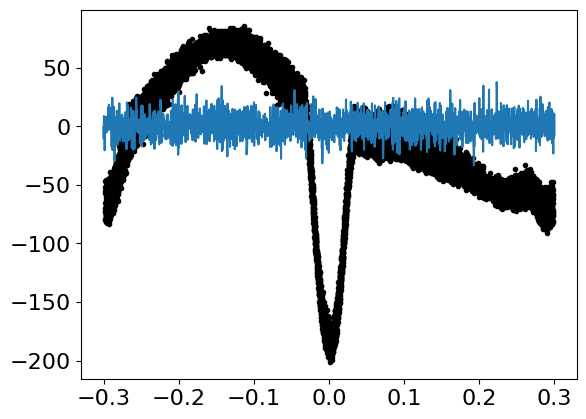

In [147]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))
# for data_var in flat_samps.data_vars.keys():
#     print(data_var)
plt.figure()



# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])
lcpred = np.percentile(flat_samps['lc_pred'], 50,axis=0)
mod_phase = np.linspace(-.3, 0.3, len(lcpred))

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
m = np.abs(x_fold) < 0.3
plt.plot(
    x_fold[m], y[mask][m] - np.std(lcpred), ".k", label="data", zorder=-1000
)



plt.plot(mod_phase, lcpred)